In [82]:
# GENERAL PACKAGE IMPORT
# ----------------------
import sys
sys.path.append('/Users/huangwp/Documents/git/HIL-Sim/flexlab/db_layer') 
from db_interface import DB_Interface
import requests
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
from io import StringIO

import datetime as dt
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import date2num
import seaborn
import timeit
import json
import pickle

import matplotlib.pyplot as plt
#import oa_temp as oa
#import sa_temp as sa
import db_plotting
from matplotlib import gridspec

In [83]:
data24 = pd.read_csv('data24_revised.csv', parse_dates = True, index_col = 0)
data25 = pd.read_csv('data25_revised.csv', parse_dates = True, index_col = 0)

data24['datetime'] = pd.to_datetime(data24['datetime'])
data25['datetime'] = pd.to_datetime(data25['datetime'])

In [84]:
print(data24.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

In [85]:
data24['precool_window'] = 0
data24['gta_window'] = 0

data25['precool_window'] = 0
data25['gta_window'] = 0

precool_st = datetime.time(10,0,0)
precool_en = datetime.time(14,0,0)

gta_st = datetime.time(14,0,0)
gta_en = datetime.time(18,0,0)

print(type(data24['datetime'].iloc[0]))
print(type(datetime.time(14,0,0)))

data24['date'] = data24['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data24['time'] = data24['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

data25['date'] = data25['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data25['time'] = data25['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

gta_ts = (data24['time'] > gta_st) & (data24['time'] <= gta_en)
precool_ts = (data24['time'] > precool_st) & (data24['time'] <= precool_en)

#print(gta_ts)
data24['precool_window'][precool_ts] = 1
data24['gta_window'][gta_ts] = 1

data25['precool_window'][precool_ts] = 1
data25['gta_window'][gta_ts] = 1

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.time'>


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/353186504.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data24['precool_window'][precool_ts] = 1
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/353186504.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data24['gta_window'][gta_ts] = 1
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/353186504.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

### Metrics

In [86]:
data24 = data24.assign(COP='COP') 
#data24['COP'] = data24['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data24['COP'] = 2.9

data25 = data25.assign(COP='COP') 
#data25['COP'] = data25['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data25['COP'] = 2.9

In [87]:
data24 = data24.assign(chiller = 'Chiller_load') 
data24['Chiller_load'] = (data24['1A-Th-Chilled Water']/data24['COP'])*-1
data24['cooling_power [W]'] = data24['1A-El-AHU'] + data24['1A-El-Exhaust Fan'] + data24['1A-El-CHWP'] + data24['Chiller_load']

data25 = data25.assign(chiller = 'Chiller_load') 
data25['Chiller_load'] = (data25['1B-Th-Chilled Water']/data25['COP'])*-1
data25['cooling_power [W]'] = data25['1B-El-AHU'] + data25['1B-El-Exhaust Fan'] + data25['1B-El-CHWP'] + data25['Chiller_load']

In [88]:
day_range1=[8,30,31]
day_range2=[9,8,9]

day_range=day_range1

en_1a = []
en_1b = []
# define dates for the calculation

#for day in range(15, 20):    
    #mask_1 = data24['date'] == datetime.date(2021, 9, day)

for day in range(day_range[1], day_range[2]+1):    
    mask_1 = data24['date'] == datetime.date(2021, day_range[0], day)
    print(day)
    day_en_1a = round((data24['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
    
    day_en_1b = round((data25['cooling_power [W]'][mask_1].sum()/4000),2)
    #print(day_en_1b)
    en_1b.append(day_en_1b)
    
    
day_range=day_range2

for day in range(day_range[1], day_range[2]+1):    
    mask_1 = data24['date'] == datetime.date(2021, day_range[0], day)
    print(day)
    day_en_1a = round((data24['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
    
    day_en_1b = round((data25['cooling_power [W]'][mask_1].sum()/4000),2)
    #print(day_en_1b)
    en_1b.append(day_en_1b)


30
31
8
9


In [89]:
#test_day_mask = (((data25['date'] >= datetime.date(2021, 9, 15)) & (data25['date'] <= datetime.date(2021, 9, 19))))
#test_day_mask = (((data25['date'] >= datetime.date(2021, 9, 15)) & (data25['date'] <= datetime.date(2021, 9, 19))))
# boolean_date=(df.index > start_date) & (df.index < end_date)

day_range=day_range1
test_day_mask1=(data25['date'] >= datetime.date(2021, day_range[0], day_range[1])) & (data25['date'] <= datetime.date(2021, day_range[0], day_range[2]))

day_range=day_range2
test_day_mask2=(data25['date'] >= datetime.date(2021, day_range[0], day_range[1])) & (data25['date'] <= datetime.date(2021, day_range[0], day_range[2]))

test_day_mask=(test_day_mask1==True) | (test_day_mask2==True)

In [90]:
print(test_day_mask)

time
2021-08-29 23:45:00    False
2021-08-30 00:00:00     True
2021-08-30 00:15:00     True
2021-08-30 00:30:00     True
2021-08-30 00:45:00     True
                       ...  
2021-09-09 22:45:00     True
2021-09-09 23:00:00     True
2021-09-09 23:15:00     True
2021-09-09 23:30:00     True
2021-09-09 23:45:00     True
Name: date, Length: 1057, dtype: bool


In [91]:
data24 = data24[test_day_mask]
data25 = data25[test_day_mask]

In [92]:
data24['cooling_power [W]'][mask_1][gta_ts]

time
2021-09-09 14:15:00    1487.545546
2021-09-09 14:30:00    1466.881195
2021-09-09 14:45:00    1429.749612
2021-09-09 15:00:00    1448.551073
2021-09-09 15:15:00    1471.285858
2021-09-09 15:30:00    1438.548104
2021-09-09 15:45:00    1283.604012
2021-09-09 16:00:00    1035.163857
2021-09-09 16:15:00    1008.648425
2021-09-09 16:30:00     958.818578
2021-09-09 16:45:00     855.532918
2021-09-09 17:00:00     933.676906
2021-09-09 17:15:00     930.914094
2021-09-09 17:30:00     789.425634
2021-09-09 17:45:00     640.212178
2021-09-09 18:00:00     635.409729
Name: cooling_power [W], dtype: float64

In [93]:
data24['cooling_power [W]'][mask_1][precool_ts]

time
2021-09-09 10:15:00     835.487797
2021-09-09 10:30:00     328.673152
2021-09-09 10:45:00     230.454238
2021-09-09 11:00:00     867.617193
2021-09-09 11:15:00    1318.871079
2021-09-09 11:30:00    1393.992180
2021-09-09 11:45:00    1419.557578
2021-09-09 12:00:00    1233.932886
2021-09-09 12:15:00    1057.058372
2021-09-09 12:30:00    1220.337460
2021-09-09 12:45:00    1437.414385
2021-09-09 13:00:00    1535.023921
2021-09-09 13:15:00    1544.696564
2021-09-09 13:30:00    1362.749551
2021-09-09 13:45:00            NaN
2021-09-09 14:00:00    1516.814639
Name: cooling_power [W], dtype: float64

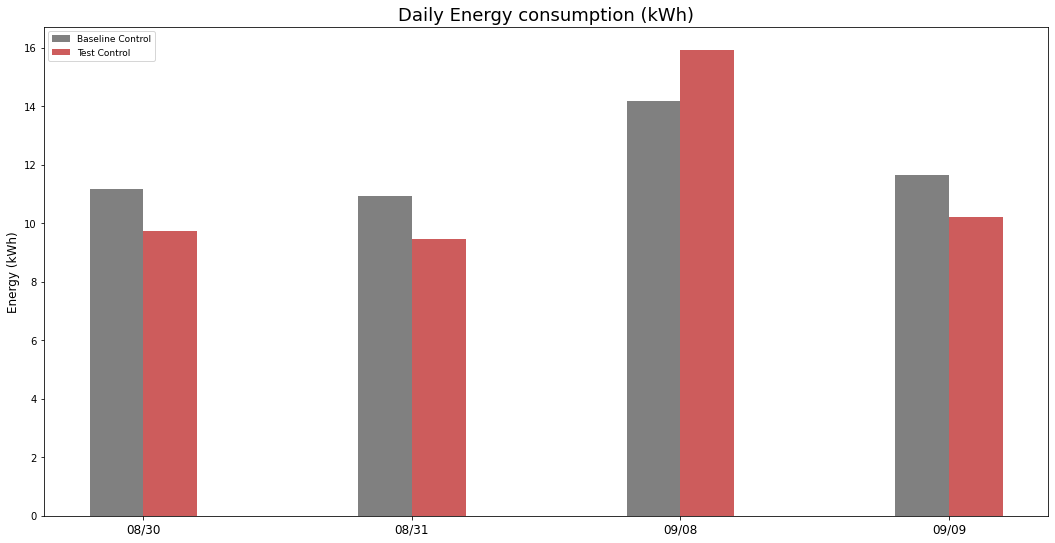

In [94]:
db_plotting.energy_plot(data25, en_1a, en_1b, 'Daily Energy consumption (kWh)', 'Energy (kWh)')

In [95]:
print(en_1a)

[11.16, 10.94, 14.18, 11.65]


In [96]:
print(en_1b)

[9.74, 9.45, 15.92, 10.2]


### Shed

In [97]:
data25['G36 Demand Shed'] = data25['cooling_power [W]'] - data24['cooling_power [W]']

shed_1a = []
shed_1b = []

# define dates for the calculation
day_range=day_range1
for day in range(day_range[1],day_range[2]+1):    
    mask_1 = data24['date'] == datetime.date(2021, day_range[0], day)
    #print(day) 
    day_shed_1a = (data24['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1a.append(day_shed_1a)
    
    day_shed_1b = (data25['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1b.append(day_shed_1b)

    
day_range=day_range2
for day in range(day_range[1],day_range[2]+1):    
    mask_1 = data24['date'] == datetime.date(2021, day_range[0], day)
    #print(day) 
    day_shed_1a = (data24['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1a.append(day_shed_1a)
    
    day_shed_1b = (data25['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1b.append(day_shed_1b)


[1088.7429436258553, 992.9164009938763, 1280.820997338003, 1113.3729824582622]
['08/30', '08/31', '09/08', '09/09']
[469.2549572787666, 538.4940189601497, 734.688128624412, 627.9726677240884]


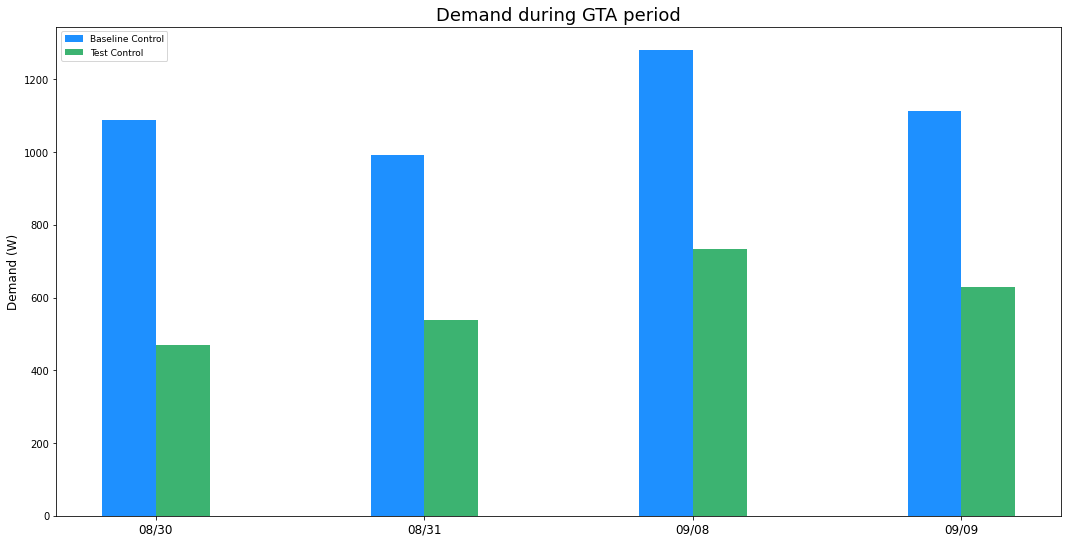

In [98]:
print(shed_1a)
db_plotting.shed_demand_plot(data25, shed_1a, shed_1b, 'Demand during GTA period', 'Demand (W)')

### SHIFT

In [99]:
data25['G36 Demand shift'] = data25['cooling_power [W]'] - data24['cooling_power [W]']

precool_1a = []
precool_1b = []

# define dates for the calculation
day_range=day_range1
for day in range(day_range[1],day_range[2]+1):    
    mask_1 = data25['date'] == datetime.date(2021, day_range[0], day)
    #print(mask_1) 
        
    day_precool_1a = (data24['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1a.append(day_precool_1a)
    print(day_precool_1a)
    day_precool_1b = (data25['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1b.append(day_precool_1b)
    
day_range=day_range2
for day in range(day_range[1],day_range[2]+1):    
    mask_1 = data25['date'] == datetime.date(2021, day_range[0], day)
    #print(mask_1) 
        
    day_precool_1a = (data24['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1a.append(day_precool_1a)
    print(day_precool_1a)
    day_precool_1b = (data25['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1b.append(day_precool_1b)
    


960.3557987560182
995.1343891839206
1359.07135815735
1153.5120664776537


[960.3557987560182, 995.1343891839206, 1359.07135815735, 1153.5120664776537]
['08/30', '08/31', '09/08', '09/09']
[1114.2491130955787, 1043.2412972168563, 1340.4766839012443, 1266.1315104332555]


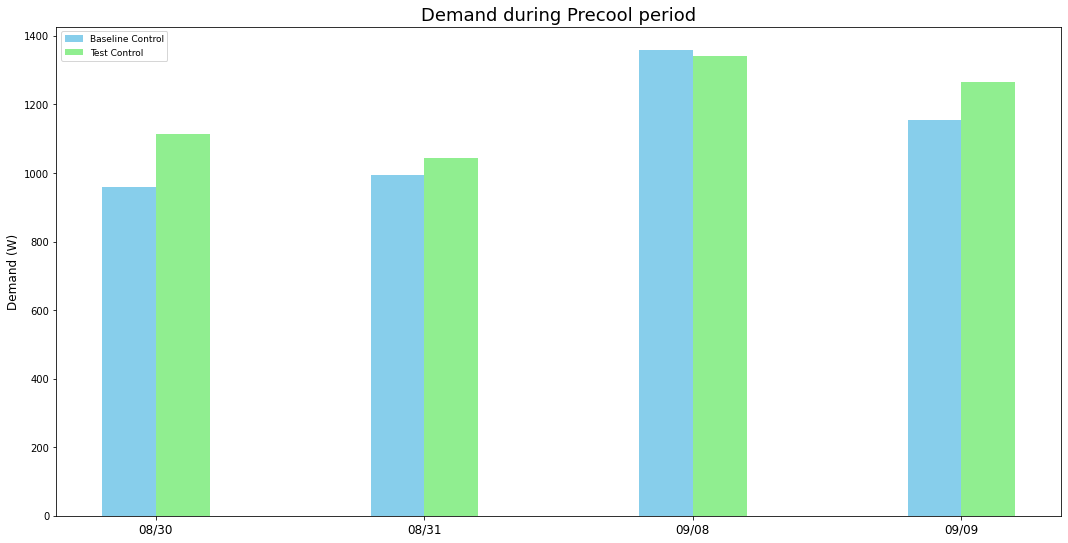

In [100]:
print(precool_1a)
db_plotting.precool_demand_plot(data25, precool_1a, precool_1b, 'Demand during Precool period', 'Demand (W)')

### Thermal comfort

/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/890013529.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .4, wspace=.15)


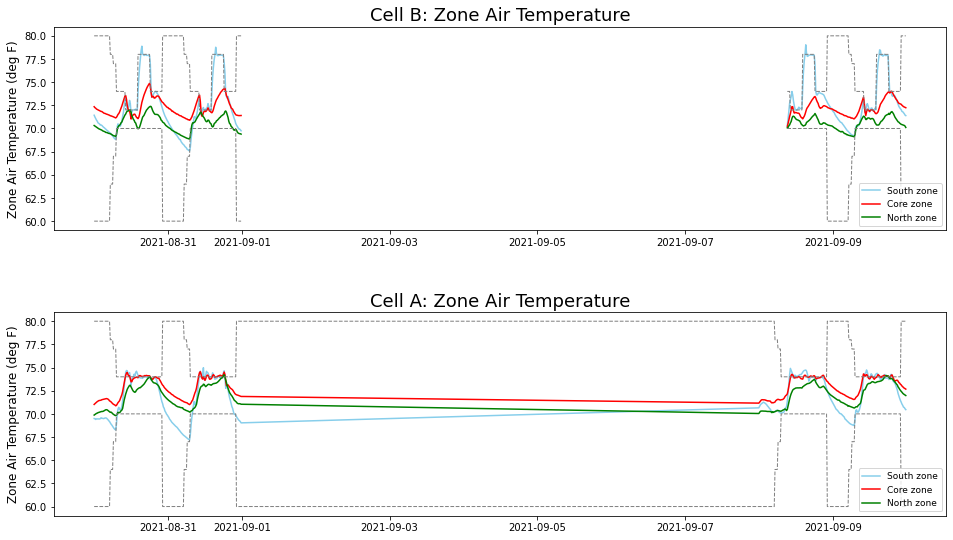

In [101]:
fig, (ax1, ax) = plt.subplots(nrows = 2, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (16,9))
fig.subplots_adjust(hspace = .4, wspace=.15)

ax1.plot(data25['1B-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax1.plot(data25['1B-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax1.plot(data25['1B-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax1.plot(data25['1B-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax1.plot(data25['1B-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax.plot(data24['1A-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax.plot(data24['1A-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax.plot(data24['1A-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax.plot(data24['1A-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax.plot(data24['1A-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)
ax.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

#ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
#ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)
ax.set_title('Cell A: Zone Air Temperature', fontsize = 18)

ax.legend(fontsize = 9, loc = 4)
ax1.legend(fontsize = 9, loc = 4)

Text(0.5, 0.98, 'Cell A: Zone Air Temperature')

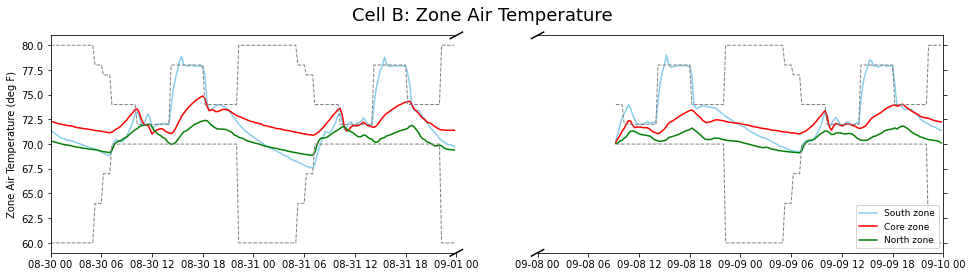

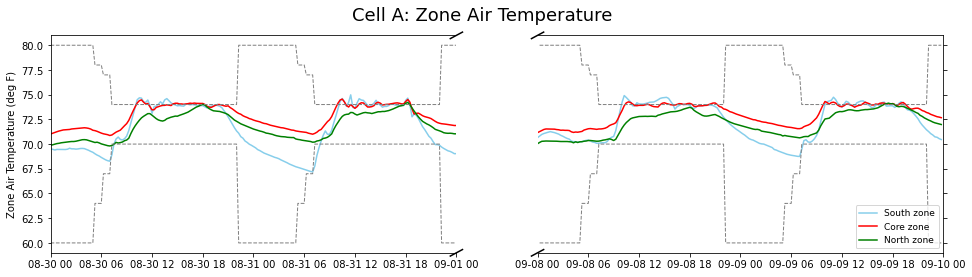

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', edgecolor='k',figsize = (16,4))
#fig.subplots_adjust(hspace = .4, wspace=.15)


# plot the same data on both axes
#ax.plot(x, y)
#ax2.plot(x, y)


ax1.plot(data25['1B-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax1.plot(data25['1B-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax1.plot(data25['1B-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax1.plot(data25['1B-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax1.plot(data25['1B-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax2.plot(data25['1B-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax2.plot(data25['1B-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax2.plot(data25['1B-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax2.plot(data25['1B-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax2.plot(data25['1B-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')


day_range=day_range1

ax1.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, 9,1)]) 
#ax1.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)])
day_range=day_range2
ax2.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)]) 



# hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelleft='off')
ax2.yaxis.tick_right()
#ax2.tick_params(labelright='off')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)



#ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

#ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)

ax2.legend(fontsize = 9, loc = 4)


ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 10)


#ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
#ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


fig.suptitle('Cell B: Zone Air Temperature', fontsize = 18)

#fig.subplots_adjust(hspace=14)



# -------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', edgecolor='k',figsize = (16,4))
#fig.subplots_adjust(hspace = .4, wspace=.15)


# plot the same data on both axes
#ax.plot(x, y)
#ax2.plot(x, y)


ax1.plot(data24['1A-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax1.plot(data24['1A-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax1.plot(data24['1A-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax1.plot(data24['1A-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax1.plot(data24['1A-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax2.plot(data24['1A-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax2.plot(data24['1A-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax2.plot(data24['1A-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax2.plot(data24['1A-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax2.plot(data24['1A-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')


day_range=day_range1

ax1.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, 9,1)]) 
#ax1.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)])
day_range=day_range2
ax2.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)]) 



# hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelleft='off')
ax2.yaxis.tick_right()
#ax2.tick_params(labelright='off')

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)



#ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

#ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)

ax2.legend(fontsize = 9, loc = 4)


ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 10)


#ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
#ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


fig.suptitle('Cell A: Zone Air Temperature', fontsize = 18)

#fig.subplots_adjust(hspace=14)



# -------------------------------------------------------------------

In [103]:
data24 = data24.assign(nor_zat_deg = 'nor_zat_deg') 
#for i in range(len(data20.index)):

def zat_col(df_zat, df_cool_sp):
    df_zat = df_zat.apply(lambda x: (x-32)/1.8)
    df_cool_sp = df_cool_sp.apply(lambda x: (x-32)/1.8)
    
    df_zat_deg = df_zat - df_cool_sp
    df_zat_deg = df_zat_deg.apply(lambda x:0 if x <= 0 else x)
    return (df_zat_deg)   # this function calculate the difference of all the days when actual temperature is 
# higher than the cooling set point

In [104]:
data24['nor_zat_deg'] = zat_col(data24['1A-VAV1-Zn_Temp'], data24['1A-VAV1-OccupiedCoolingSetpt'])
data24['cor_zat_deg'] = zat_col(data24['1A-VAV2-Zn_Temp'], data24['1A-VAV2-OccupiedCoolingSetpt'])
data24['sou_zat_deg'] = zat_col(data24['1A-VAV3-Zn_Temp'], data24['1A-VAV3-OccupiedCoolingSetpt'])

data25['nor_zat_deg'] = zat_col(data25['1B-VAV1-Zn_Temp'], data25['1B-VAV1-OccupiedCoolingSetpt'])
data25['cor_zat_deg'] = zat_col(data25['1B-VAV2-Zn_Temp'], data25['1B-VAV2-OccupiedCoolingSetpt'])
data25['sou_zat_deg'] = zat_col(data25['1B-VAV3-Zn_Temp'], data25['1B-VAV3-OccupiedCoolingSetpt'])

# just that the nor_zat_deg is the column of the  overshoot

#data22['nor_zat_deg'] = zat_col(data22['VAV: North Zone Room Air Temperature'], data22['Tcool_SP'])
#data22['cor_zat_deg'] = zat_col(data22['VAV: Core Zone Room Air Temperature'], data22['Tcool_SP'])
#data22['sou_zat_deg'] = zat_col(data22['VAV: South Zone Room Air Temperature'], data22['Tcool_SP'])

#data23['nor_zat_deg'] = zat_col(data23['VAV: North Zone Room Air Temperature'], data23['Tcool_SP'])
#data23['cor_zat_deg'] = zat_col(data23['VAV: Core Zone Room Air Temperature'], data23['Tcool_SP'])
#data23['sou_zat_deg'] = zat_col(data23['VAV: South Zone Room Air Temperature'], data23['Tcool_SP'])

#data24['nor_zat_deg'] = zat_col(data24['VAV: North Zone Room Air Temperature'], data24['Tcool_SP'])
#data24['cor_zat_deg'] = zat_col(data24['VAV: Core Zone Room Air Temperature'], data24['Tcool_SP'])
#data24['sou_zat_deg'] = zat_col(data24['VAV: South Zone Room Air Temperature'], data24['Tcool_SP'])

In [105]:
#print(data20['nor_zat_deg'], data23['nor_zat_deg'])

In [106]:
def calc_stats(df, df_temp):
   
    overshoot = []
    mean = []
    median = []
    std = []
    oc_st = datetime.time(7,0,0)
    oc_en = datetime.time(19,0,0)

    oc_time = ((df['time'] >= oc_st) & (df['time'] <= oc_en))

    #print(df_temp, df['Tcool_SP'])
    day_range=day_range1
        
    for day in range(day_range[1],day_range[2]+1):    
        mask_1 = data25['date'] == datetime.date(2021, day_range[0], day)
        daily_mean = df_temp[mask_1][oc_time].mean()
        daily_median = df_temp[mask_1][oc_time].median()
        #print('Variance', df[df[i] > target[i]].var())
        daily_std = df_temp[mask_1][oc_time].std()
        
        mean.append(daily_mean)
        median.append(daily_median)
        std.append(daily_std)
        
    #for i in range(len(df.index)):
        #if (df['time'][i] <= oc_en) & (df['time'][i] >= oc_st):
        #print(df_temp[i], df['Tcool_SP'][i], df_temp[i] - df['Tcool_SP'][i])
        daily_shoot = sum(df_temp[mask_1][oc_time]*.25)
        counter = sum(df_temp[mask_1][oc_time]>0)
        overshoot.append(daily_shoot)
        #print(counter)
        
        #print(day)
    #print(mean, median, std)
    
    day_range=day_range2
        
    for day in range(day_range[1],day_range[2]+1):    
        mask_1 = data25['date'] == datetime.date(2021, day_range[0], day)
        daily_mean = df_temp[mask_1][oc_time].mean()
        daily_median = df_temp[mask_1][oc_time].median()
        #print('Variance', df[df[i] > target[i]].var())
        daily_std = df_temp[mask_1][oc_time].std()
        
        mean.append(daily_mean)
        median.append(daily_median)
        std.append(daily_std)
        
    #for i in range(len(df.index)):
        #if (df['time'][i] <= oc_en) & (df['time'][i] >= oc_st):
        #print(df_temp[i], df['Tcool_SP'][i], df_temp[i] - df['Tcool_SP'][i])
        daily_shoot = sum(df_temp[mask_1][oc_time]*.25)
        counter = sum(df_temp[mask_1][oc_time]>0)
        overshoot.append(daily_shoot)
        
        #print(day)
    #print(mean, median, std)
    
    
    
    

    
    return(overshoot, mean, median, std) 
# for each day 7am to 7pm, calclate the mean, median, and std of the excess temperature , overshoot calculation
# is a bit more involved

In [107]:
print(data24.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

In [108]:
data24_nor_zat_deg, data24_nor_mean, data24_nor_median, data24_nor_std = calc_stats(data24, data24['nor_zat_deg'])
data24_cor_zat_deg, data24_cor_mean, data24_cor_median, data24_cor_std = calc_stats(data24, data24['cor_zat_deg'])
data24_sou_zat_deg, data24_sou_mean, data24_sou_median, data24_sou_std = calc_stats(data24, data24['sou_zat_deg'])

data25_nor_zat_deg, data25_nor_mean, data25_nor_median, data25_nor_std = calc_stats(data25, data25['nor_zat_deg'])
data25_cor_zat_deg, data25_cor_mean, data25_cor_median, data25_cor_std = calc_stats(data25, data25['cor_zat_deg'])
data25_sou_zat_deg, data25_sou_mean, data25_sou_median, data25_sou_std = calc_stats(data25, data25['sou_zat_deg'])


# first variable is the complex overshoot, the next 3 are mean, median, and std previously calculated.

In [109]:
print(data24_nor_zat_deg, data24_nor_mean, data25_nor_median, data25_nor_std)

[0.002777777777777324, 0.04722222222222339, 0.0, 0.05555555555555536] [0.0002267573696144754, 0.003854875283446807, 0.0, 0.004535147392290233] [0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


In [110]:
scenario_dict = {}
scenario_dict[1] = calc_stats(data24, data24['nor_zat_deg'])
scenario_dict[2] = calc_stats(data24, data24['cor_zat_deg'])
scenario_dict[3] = calc_stats(data24, data24['sou_zat_deg'])

scenario_dict[4] = calc_stats(data25, data25['nor_zat_deg'])
scenario_dict[5] = calc_stats(data25, data25['cor_zat_deg'])
scenario_dict[6] = calc_stats(data25, data25['sou_zat_deg'])

# look like this part is redundant

In [111]:
#print(scenario_dict)

In [112]:
scenario_dict = {'data24': {"nor": calc_stats(data24, data24['nor_zat_deg']),
                            "cor": calc_stats(data24, data24['cor_zat_deg']), 
                            "sou": calc_stats(data24, data24['sou_zat_deg'])}, 
                 
                 'data25': {"nor": calc_stats(data25, data25['nor_zat_deg']),
                            "cor": calc_stats(data25, data25['cor_zat_deg']), 
                            "sou": calc_stats(data25, data25['sou_zat_deg'])}}

# now it is a dictionary on all the overshoot, mean, median, std statistics

In [113]:
#print(scenario_dict)

In [114]:
print(scenario_dict['data25']['sou'])  # This prints the data25 set of overshoot, mean, median, and std
print(scenario_dict['data25']['sou'][0][1:5]) # [0] means overshoot, 1:5 means from second day to sixth day
# since we only have 4th day, so we only go up to 4th day! 

([1.2347222222222252, 1.287500000000005, nan, 0.8180555555555573], [0.10079365079365103, 0.10510204081632693, 0.17902777777777734, 0.06678004535147407], [0.0, 0.0, 0.0, 0.0], [0.275625924407994, 0.3056562055077545, 0.36528377634193643, 0.18447487545956187])
[1.287500000000005, nan, 0.8180555555555573]


In [115]:
print(sum(data24_nor_zat_deg), sum(data25_nor_zat_deg))
print(sum(data24_cor_zat_deg), sum(data25_cor_zat_deg))
print(sum(data24_sou_zat_deg), sum(data25_sou_zat_deg))  # just a check of summing of overshoot data for each day

0.10555555555555607 nan
1.6055555555555667 nan
3.455555555555578 nan


In [116]:
print(data24_nor_zat_deg,data24_cor_zat_deg,data24_sou_zat_deg)

[0.002777777777777324, 0.04722222222222339, 0.0, 0.05555555555555536] [0.40416666666666945, 0.5819444444444448, 0.2305555555555614, 0.38888888888889106] [0.6791666666666707, 0.8513888888888932, 1.1791666666666778, 0.7458333333333362]


In [117]:
print(data25_nor_zat_deg,data25_cor_zat_deg,data25_sou_zat_deg)

[0.0, 0.0, nan, 0.0] [0.5444444444444452, 0.47916666666666785, nan, 0.1374999999999984] [1.2347222222222252, 1.287500000000005, nan, 0.8180555555555573]


['08/30', '08/31', '09/08', '09/09']
[datetime.date(2021, 8, 30) datetime.date(2021, 8, 31)
 datetime.date(2021, 9, 8) datetime.date(2021, 9, 9)]
[0.002777777777777324, 0.04722222222222339, 0.0, 0.05555555555555536]


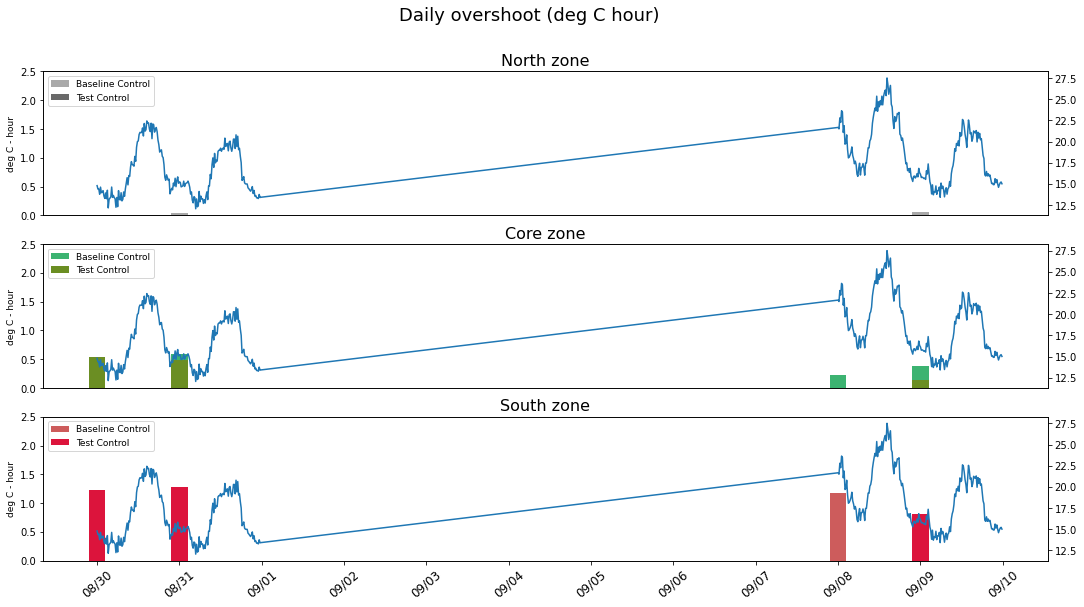

In [118]:
# key for metrics to be plotted in the scenario dictionary; {1:'overshoot', 2:'mean', 3:'median', 4:'std_dev'}
title_dict = {1: 'Daily overshoot (deg C hour)', 2:'Daily overshoot (mean)', 3:'Daily overshoot (median)' , 4:'Daily overshoot (standard deviation)'}
ylabel = {1: 'deg C - hour', 2: 'deg C', 3: 'deg C', 4: 'deg C'}
db_plotting.thermal_comfort_plot(data24, scenario_dict['data24']['nor'], scenario_dict['data25']['nor'], 
                                 scenario_dict['data24']['cor'], scenario_dict['data25']['cor'], 
                                 scenario_dict['data24']['sou'], scenario_dict['data25']['sou'],
                                 scenario_dict, 0, ylabel[1], title_dict[1])
# define a title and ylabel dictionary 
# each input data is each room's overshoot, mean, median, and std

### Test code2 start

In [119]:
import matplotlib.dates as mdates

def thermal_comfort_plot3(data_1, inp_1, inp_2, inp_3, inp_4, inp_5, inp_6, scenario_dict, metric, ylabel, title_dict):
    
    # data_1 is the full RAW data, have 6 inputs, 
    
    #fig, (ax, ax1, ax2) = plt.subplots(nrows = 3, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',
                                      # figsize = (18,9))
    
    
    
    
    
    #fig.subplots_adjust(hspace = .2, wspace=.15)
    # so the row is 3 and columns is 1 

    inp_day = data_1['date'].unique() # capture unique dates from the date column
    inp_day = inp_day.tolist() #convert to a list for unique days
    import datetime
    #from datetime import datetime, timedelta
    for i in range(len(inp_day)):
        inp_day[i]=datetime.datetime.combine(inp_day[i], datetime.datetime.min.time())
    
    
    # create labels for each date of the test
    labels = []
    labels1 = []
    for i in range(0,len(inp_day)):
        labels.append(inp_day[i].strftime('%m/%d'))

    print(labels) # print out the variable "labels" with unique days
    width = datetime.timedelta(hours = 3)
    x = np.array(inp_day)
    #bar1=np.arange(len(x))
    #bar2=[i+width for i in bar1]
    
    print(x)
    print(inp_1[metric][0:len(labels)+1])# print the 0:overshoot, 1:mean data for all days from the first input
    
    shift1 = datetime.timedelta(hours = 1.5)
    shift2 = datetime.timedelta(hours = 4.5)
    
    #shift = pd.to_timedelta('6h')
    
    #shift=0.2
    
    
    fig1, (ax1, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', edgecolor='k',figsize = (18,3))
    day_range=day_range1
    #ax1.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)])
    ax1.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, 9,1,0,0)])
    day_range=day_range2
    ax2.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)]) 
    
    #ax.xaxis_date()
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    
    ax12 = ax1.twinx()
    ax12.plot(data_1['1B-OAT-1'])
    ax22 = ax2.twinx()
    ax22.plot(data_1['1B-OAT-1'])
    #ax.set_xticks(range(len(labels)))
    
    
    
    
    #ax1.bar(inp_1.index-shift, inp_1[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'darkgrey')
    #ax2.bar(inp_1.index-shift, inp_1[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'darkgrey')
    #ax1.bar(inp_2.index+shift, inp_2[metric][0:len(labels)+1], width = width, label='Test Control', color = 'dimgrey')
    #ax2.bar(inp_2.index+shift, inp_2[metric][0:len(labels)+1], width = width, label='Test Control', color = 'dimgrey')
    
    
    
    
    ax1.bar(x+shift1, inp_1[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'darkgrey')
    ax2.bar(x+shift1, inp_1[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'darkgrey')
    ax1.bar(x+shift2, inp_2[metric][0:len(labels)+1], width = width, label='Test Control', color = 'dimgrey')
    ax2.bar(x+shift2, inp_2[metric][0:len(labels)+1], width = width, label='Test Control', color = 'dimgrey')
    # plot 1st and 2nd input of the 0:overshoot, 1:mean data with the width data defined above
    
    
    
    
    plt.subplots_adjust(wspace=0.05)
    # hide the spines between ax and ax2
    ax1.spines['right'].set_visible(False)
    ax12.spines['right'].set_visible(False)
    ax12.tick_params(labelright=False,right=False)
    ax2.spines['left'].set_visible(False)
    ax22.spines['left'].set_visible(False)
    ax22.spines['right'].set_visible(False)
    ax1.yaxis.tick_left()
    #ax1.tick_params(labelleft='off')
    ax2.yaxis.tick_right()
    ax2.tick_params(right=False)

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)



    #ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

    #ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)



    ax1.set_ylabel(ylabel, fontsize = 9)


    #ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
    #ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


    fig1.suptitle(title_dict+'\n \nNorth zone', fontsize = 16,y=1.15)
    
    ax1.legend(fontsize = 9, loc = 2)
    
    
    #ax2.set_xticks(range(len(labels)))
    if metric == 0:
        ax1.set_ylim(0,2.5)
        ax2.set_ylim(0,2.5)
    else:
        ax1.set_ylim(0,0.5)
        ax2.set_ylim(0,0.5)
    # --------------------------------------------------------------------------------
    
     #plot 3rd and 4th input of the 0:overshoot, 1:mean data 


    

    fig2, (ax3, ax4) = plt.subplots(1,2, sharey=True, facecolor='w', edgecolor='k',figsize = (18,3))
    day_range=day_range1
    #ax3.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)])
    ax3.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, 9,1,0,0)])
    day_range=day_range2
    ax4.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)]) 
    
    #ax.xaxis_date()
    ax3.get_xaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)
    
    ax32 = ax3.twinx()
    ax32.plot(data_1['1B-OAT-1'])
    ax42 = ax4.twinx()
    ax42.plot(data_1['1B-OAT-1'])
    #ax.set_xticks(range(len(labels)))
    
    
    
    
    ax3.bar(x+shift1, inp_3[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'mediumseagreen')
    ax4.bar(x+shift1, inp_3[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'mediumseagreen')
    ax3.bar(x+shift2, inp_4[metric][0:len(labels)+1], width = width, label='Test Control', color = 'olivedrab')
    ax4.bar(x+shift2, inp_4[metric][0:len(labels)+1], width = width, label='Test Control', color = 'olivedrab')
    
    
    # plot 1st and 2nd input of the 0:overshoot, 1:mean data with the width data defined above
    
    
    plt.subplots_adjust(wspace=0.05)
    ax3.spines['right'].set_visible(False)
    ax32.spines['right'].set_visible(False)
    ax32.tick_params(labelright=False,right=False)
    ax4.spines['left'].set_visible(False)
    ax42.spines['left'].set_visible(False)
    ax42.spines['right'].set_visible(False)
    ax3.yaxis.tick_left()
    #ax1.tick_params(labelleft='off')
    ax4.yaxis.tick_right()
    ax4.tick_params(right=False)
    
    
    
    

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot((1-d,1+d), (-d,+d), **kwargs)
    ax3.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
    ax4.plot((-d,+d), (1-d,1+d), **kwargs)
    ax4.plot((-d,+d), (-d,+d), **kwargs)



    #ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

    #ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)



    ax3.set_ylabel(ylabel, fontsize = 9)


    #ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
    #ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


    fig2.suptitle('Core zone', fontsize = 16)
    
    ax3.legend(fontsize = 9, loc = 2)
    
    
    #ax2.set_xticks(range(len(labels)))
    if metric == 0:
        ax3.set_ylim(0,2.5)
        ax4.set_ylim(0,2.5)
    else:
        ax3.set_ylim(0,0.5)
        ax4.set_ylim(0,0.5)    
    
    # -------------------------------------------------------------------------------------------
    

    
    
    fig3, (ax5, ax6) = plt.subplots(1,2, sharey=True, facecolor='w', edgecolor='k',figsize = (18,3))
    day_range=day_range1
    #ax5.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)])
    ax5.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, 9,1,0,0)])
    day_range=day_range2
    ax6.set_xlim([datetime.datetime(2021, day_range[0], day_range[1],0,0),datetime.datetime(2021, day_range[0], day_range[2]+1,0,0)])  
    
    #ax.xaxis_date()
    #ax1.get_xaxis().set_visible(False)
    #ax2.get_xaxis().set_visible(False)
    
    ax52 = ax5.twinx()
    ax52.plot(data_1['1B-OAT-1'])
    ax62 = ax6.twinx()
    ax62.plot(data_1['1B-OAT-1'])
    #ax.set_xticks(range(len(labels)))
    
    
    
    
    ax5.bar(x+shift1, inp_5[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'indianred')
    ax6.bar(x+shift1, inp_5[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'indianred')
    ax5.bar(x+shift2, inp_6[metric][0:len(labels)+1], width = width, label='Test Control', color = 'crimson')
    ax6.bar(x+shift2, inp_6[metric][0:len(labels)+1], width = width, label='Test Control', color = 'crimson')
    
    
    # plot 1st and 2nd input of the 0:overshoot, 1:mean data with the width data defined above
    
    
    
    plt.subplots_adjust(wspace=0.05)
    ax5.spines['right'].set_visible(False)
    ax52.spines['right'].set_visible(False)
    ax52.tick_params(labelright=False,right=False)
    ax6.spines['left'].set_visible(False)
    ax62.spines['left'].set_visible(False)
    ax62.spines['right'].set_visible(False)
    ax5.yaxis.tick_left()
    ax6.yaxis.tick_right()
    ax6.tick_params(right=False)
    
    

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax5.transAxes, color='k', clip_on=False)
    ax5.plot((1-d,1+d), (-d,+d), **kwargs)
    ax5.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax6.transAxes)  # switch to the bottom axes
    ax6.plot((-d,+d), (1-d,1+d), **kwargs)
    ax6.plot((-d,+d), (-d,+d), **kwargs)



    #ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

    #ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)



    ax5.set_ylabel(ylabel, fontsize = 9)


    #ax1.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)]) 
    #ax.set_xlim([datetime.date(2021, 8, 26),datetime.date(2021, 9, 5)])


    fig3.suptitle('South zone', fontsize = 16)
    
    ax5.legend(fontsize = 9, loc = 2)
    
    
    #ax2.set_xticks(range(len(labels)))
    if metric == 0:
        ax5.set_ylim(0,2.5)
        ax6.set_ylim(0,2.5)
    else:
        ax5.set_ylim(0,0.5)
        ax6.set_ylim(0,0.5)   
    
    
    #ax2.xaxis_date()
    #ax2.set_xtick(bar1,x)
    ax5.set_xticklabels(x, fontsize = 12)

    ax5.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 
    for label in ax5.get_xticklabels():
        label.set_rotation(40)     # Format the x label at the last graph!
        
        
        
    ax6.set_xticklabels(x, fontsize = 12)

    ax6.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
    ax6.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 
    for label in ax6.get_xticklabels():
        label.set_rotation(40)     # Format the x label at the last graph!
    print(x)
    print(type(x))
    
    
   

['08/30', '08/31', '09/08', '09/09']
[datetime.datetime(2021, 8, 30, 0, 0) datetime.datetime(2021, 8, 31, 0, 0)
 datetime.datetime(2021, 9, 8, 0, 0) datetime.datetime(2021, 9, 9, 0, 0)]
[0.002777777777777324, 0.04722222222222339, 0.0, 0.05555555555555536]
[datetime.datetime(2021, 8, 30, 0, 0) datetime.datetime(2021, 8, 31, 0, 0)
 datetime.datetime(2021, 9, 8, 0, 0) datetime.datetime(2021, 9, 9, 0, 0)]
<class 'numpy.ndarray'>


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/1970393158.py:314: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(x, fontsize = 12)
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/1970393158.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(x, fontsize = 12)


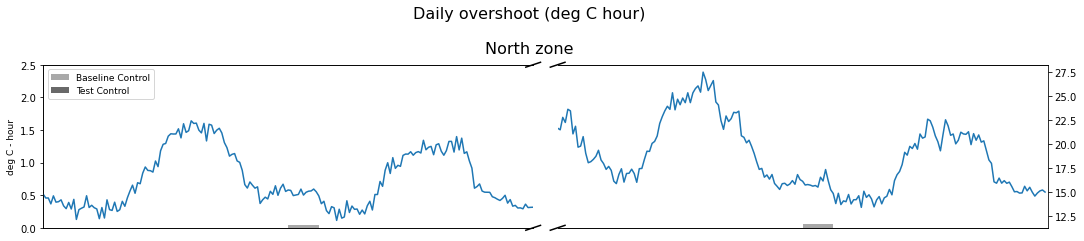

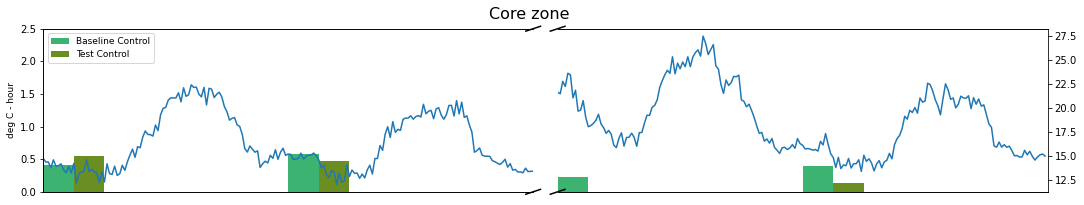

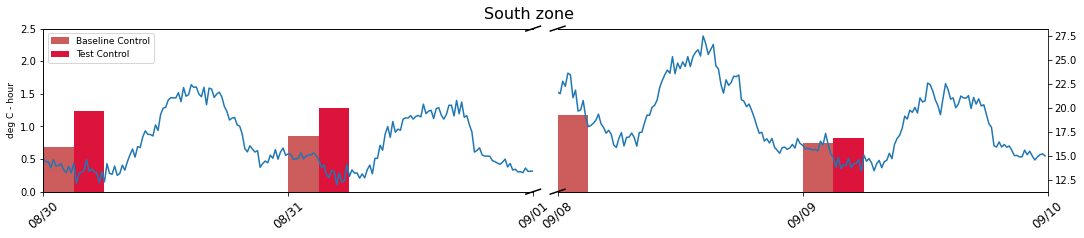

In [123]:
# key for metrics to be plotted in the scenario dictionary; {1:'overshoot', 2:'mean', 3:'median', 4:'std_dev'}
title_dict = {1: 'Daily overshoot (deg C hour)', 2:'Daily overshoot (mean)', 3:'Daily overshoot (median)' , 4:'Daily overshoot (standard deviation)'}
ylabel = {1: 'deg C - hour', 2: 'deg C', 3: 'deg C', 4: 'deg C'}
thermal_comfort_plot3(data24, scenario_dict['data24']['nor'], scenario_dict['data25']['nor'], 
                                 scenario_dict['data24']['cor'], scenario_dict['data25']['cor'], 
                                 scenario_dict['data24']['sou'], scenario_dict['data25']['sou'],
                                 scenario_dict, 0, ylabel[1], title_dict[1])
# define a title and ylabel dictionary 
# each input data is each room's overshoot, mean, median, and std

### Test code2 end

In [121]:
def demand_plot(data, list_1, list_2, list_3, list_4, title, y_label):
    fig, (ax) = plt.subplots(nrows = 1, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (18,9))
    fig.subplots_adjust(hspace = .2, wspace=.15)

    inp_day = data['date'].unique() # capture unique dates from the date column
    inp_day = inp_day.tolist() #convert to a list
    #print(inp_day)
    # create labels for each date of the test
    labels = []
    labels1 = []
    for i in range(0,len(inp_day)):
        labels.append(inp_day[i].strftime('%m/%d'))

    for i in range(0,len(inp_day)-1):
        labels1.append(inp_day[i].strftime('%m/%d'))

    x = np.arange(len(labels))
    print(labels)
    print(list_2)
    width = .2

    ax.bar(x-width*.5, list_1, width = width, label='Shed Baseline', color = 'darkviolet')
    ax.bar(x-width*.5, np.array(list_3)*-1, width = width, label='Precool Baseline', color = 'thistle')
    ax.bar(x+width*.5, list_2, width = width, label='Shed Test', color = 'orange')
    ax.bar(x+width*.5, np.array(list_4)*-1, width = width, label='Precool Test', color = 'khaki')
    ax.axhline(linewidth=1, color='black')

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels[0:len(labels)], fontsize = 12)
    ax.set_title(title, fontsize = 18)
    ax.set_ylabel(y_label, fontsize = 12)
    ax.legend(fontsize = 9, loc = 2)

['08/30', '08/31', '09/08', '09/09']
[469.2549572787666, 538.4940189601497, 734.688128624412, 627.9726677240884]


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1029/4120796508.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


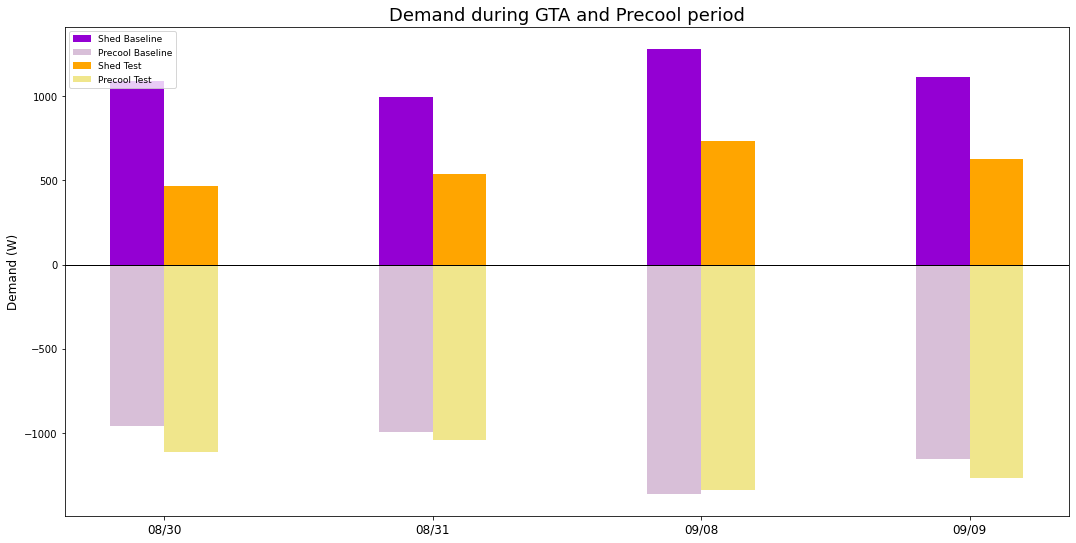

In [122]:
demand_plot(data25, shed_1a, shed_1b, precool_1a, precool_1b, 'Demand during GTA and Precool period', 'Demand (W)')